In [6]:
##############Import Library##########
import random
import numpy as np
import math
import pandas as pd
import tensorflow as tf

tf.set_random_seed(777) 

def CNN():
    tf.set_random_seed(777)  # reproducibility
    tf.reset_default_graph()

    learning_rate = 0.001
    training_epochs = 15
    batch_size = 100

    # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
    keep_prob = tf.placeholder(tf.float32)

    # input place holders
    X = tf.placeholder(tf.float32, [None, 6000])
    X_img = tf.reshape(X, [-1, 300, 20, 1])   # img 28x28x1 (black/white)
    Y = tf.placeholder(tf.float32, [None, 2])

    # L1 ImgIn shape=(?, 7, 96, 1)
    W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
    #    Conv     -> (?, 7, 96, 32)
    #    Pool     -> (?, 4, 48, 32)
    L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
    # L2 ImgIn shape=(?, 14, 14, 32)
    W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
    #    Conv      ->(?, 14, 14, 64)
    #    Pool      ->(?, 7, 7, 64)
    L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

    # L3 ImgIn shape=(?, 7, 7, 64)
    W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
    #    Conv      ->(?, 7, 7, 128)
    #    Pool      ->(?, 4, 4, 128)
    #    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
    L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
    L3 = tf.nn.relu(L3)
    L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                        1, 2, 2, 1], padding='SAME')
    L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
    print(L3)
    L3_flat = tf.reshape(L3, [-1, 128 * 12])
    print(L3_flat)
    # L4 FC 4x4x128 inputs -> 625 outputs
    W4 = tf.get_variable("W4", shape=[128 * 12, 625],
                         initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.Variable(tf.random_normal([625]))
    L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
    L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
    print(L4)
    # L5 Final FC 625 inputs -> 10 outputs
    W5 = tf.get_variable("W5", shape=[625, 2],
                         initializer=tf.contrib.layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([2]))
    logits = tf.matmul(L4, W5) + b5
    print(logits)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    predicted = tf.argmax(logits,1)
    correct_prediction = tf.equal(predicted,tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    # initialize
    # train my model
    print('Learning started. It takes sometime.')
    with tf.Session() as sess:
        # Initialize TensorFlow variables
        sess.run(tf.global_variables_initializer())

        for step in range(repeat):
            avg_cost = 0
            total_num = int(len(train_x)/batch_size)

            for i in range(total_num):
                batch_x = train_x[i*batch_size:(i+1)*batch_size]
                batch_y = train_y[i*batch_size:(i+1)*batch_size]
#                 print(len(batch_x), len(batch_y))
                sess.run( train , feed_dict={X: batch_x, Y: batch_y , keep_prob : 0.7})

            if step == repeat-1:
                ####Train Accuracy report####
                train_h, train_a = sess.run([logits, accuracy],feed_dict={X: train_x, Y: train_y, keep_prob :0.7})
                print("\nTrain Accuracy: ", train_a)
            if step % 20 == 0 :
                train_h,train_a = sess.run([logits , accuracy],feed_dict={X: train_x, Y: train_y, keep_prob :0.7})
                print("\nCurrent Accuracy : ", train_a)
                if train_a > 0.97 :
                    break
        test_h, test_a = sess.run([logits, accuracy],feed_dict={X: test_x, Y: test_y, keep_prob :1.0})
        print("\nTest Accuracy: ", test_a)
    print('Learning Finished!')
    return train_h , test_h 
    
    # Test model and check accuracy

    # if you have a OOM error, please refer to lab-11-X-mnist_deep_cnn_low_memory.py
def five_fold(data, i):
    test_data = data[data['index']==i+1]
    train_data = data[(data['index']<i+1) | (data['index']>i+1)]
    print(len(test_data), len(train_data))
    
    return train_data , test_data
def make_matrix(data, exist_gene, mechanism_dict):
    dataset_cnn = np.empty((len(data),len(mechanisms),len(exist_gene.iloc[1,:])))
    exist_gene_list = exist_gene.columns
    cnt = 0
    for i in mechanism_dict:
        for genename in mechanism_dict[i] :
            for j in range(len(exist_gene_list)):
                if genename == exist_gene_list[j] :
                    break 
            if j < len(exist_gene_list) -1  :             
                for k in range(len(data)):
                    dataset_cnn[k][cnt][j] = exist_gene[genename][k]
        cnt += 1    
    return dataset_cnn

# ##############Read Data###############
# datafilename = "/home/tjahn/Data/FinalData.csv"
# dataset = pd.read_csv(datafilename)
data = pd.read_csv("/Users/Taewan/Downloads/cp.csv")
# data = pd.read_csv('home/tjahn/Data/cp.csv')
# data = data.dropna(subset=["Cancer mechanism"])
data = data.dropna(subset=["Genes"])
# print(data)
##############Collecting gene by name of mechanism################
mechanisms = ["Tumor promoting inflammation", "Inducing angiogenesis", "Resisting cell death", 
              "Activating invasion & metastasis","Sustaining proliferative signalling",
             "Deregulating cellular energetics", "Activating invasion & metastasis (lamellapodia?)"]

mechanism_dict = {}
for i in mechanisms :
    genes = data[data["Cancer mechanism"] == i]["Genes"]
    genelist= []
    for gene in genes:
        genenames = gene.split('\r')
        for genename in genenames :
            genelist.append(genename)
    mechanism_dict[i] = genelist    
    
# for i in mechanism_dict:
# #     print(i, mechanism_dict[i])
print(genelist)

['ABI2', 'ACTA1', 'ACTR2', 'ACTR3', 'ARPC1A', 'ARPC1B', 'ARPC2', 'ARPC3', 'ARPC4', 'ARPC5', 'NCK1', 'NCKAP1', 'NTRK1', 'PIR', 'PSMA7', 'RAC1', 'WASF1', 'WASF2', 'WASF3', 'WASL']


In [7]:
dataset = pd.read_csv("/Users/Taewan/Desktop/Ahn/FinalData_GSM_gene_index_result.csv")
# dataset = pd.read_csv("home/tjahn/Data/FinalData_GSM_gene_index_result.csv")
##############Make Matrix#############
################### 15 X 6000 Matrix를 만든다. ###################
gene_list = []
for i in mechanism_dict:
    for j in mechanism_dict[i] :
        if j in gene_list :
            continue
        else :
            gene_list.append(j)
# print(gene_list)
exist_gene = dataset.loc[:,gene_list]
exist_gene=exist_gene.dropna(axis=1,how='all')
exist_gene_dataset = pd.concat([pd.DataFrame(dataset.iloc[:,0]) , exist_gene], axis= 1)
exist_gene_dataset = pd.concat([exist_gene_dataset , pd.DataFrame(dataset.iloc[:,-2:])], axis =1 )
# print(exist_gene)
# print(len(exist_gene),len(exist_gene.iloc[1,:]))
# Lab 11 MNIST and Deep learning CNN
# print(dataset_cnn)
print((len(exist_gene),len(mechanisms),len(exist_gene.iloc[1,:])))
repeat, layer, node , learning_rate, gene = 100, 3,'1500 1500 1500' ,0.01 , 60

(11913, 7, 96)


In [28]:
for j in range(5):
    nodes = list(map(int , node.split(" ")))
    #####Five fold#####
#     train_GSM = train_data.iloc[:,0]
#     test_GSM = test_data.iloc[:,0]
    #####Train Data Set#####
    train_data , test_data = five_fold(exist_gene_dataset, j)
    train_y = train_data['result'].as_matrix()
    train_x = make_matrix(train_data.iloc[:,:-2], exist_gene, mechanism_dict)
    train_x = train_x.reshape(len(train_data), len(mechanisms)*len(exist_gene.iloc[1,:]))
#     train_x = train_x.as_matrix()
#     train_y = train_data.iloc[:,-1].as_matrix()
    train_y = train_y.flatten()
    train_y = pd.get_dummies(train_y)

    #####Test Data Set#####
    test_y = test_data['result'].as_matrix()
    test_x = make_matrix(test_data.iloc[:,:-2], exist_gene, mechanism_dict)
    test_x = test_x.reshape(len(test_data), len(mechanisms)*len(exist_gene.iloc[1,:]))
#     test_x = test_data.iloc[:,1:-2]
#     test_x = test_x.as_matrix()
#     test_y = test_data.iloc[:,-1].as_matrix()
    test_y = test_y.flatten()
    test_y = pd.get_dummies(test_y)
    print(len(train_x), len(train_y) , len(test_x), len(test_y))
    cnt_train = len(train_x[1, :])
    train_h  ,test_h = (CNN())
#     train_result = pd.concat([train_GSM, train_p], axis=1)
#     train_result = pd.concat([train_result, train_h], axis =1 )
#     test_result = pd.concat([test_GSM, test_p], axis=1)
#     test_result = pd.concat([test_result, test_h], axis=1)
    
#     result_train_filename = "result_file_train" + str(j) +".csv"
#     train_result.to_csv(output_directory+result_train_filename , sep= ',')
#     result_test_filename = "result_file_test" + str(j) +".csv"
#     test_result.to_csv(output_directory+result_test_filename , sep= ',')
#     ###train h를 file로
    ###test h를 file로 

2432 9481
9481 9481 2432 2432
Tensor("dropout_2/mul:0", shape=(?, 1, 12, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 1536), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
Tensor("add_1:0", shape=(?, 2), dtype=float32)
Learning started. It takes sometime.

Current Accuracy :  0.499842


KeyboardInterrupt: 

2432 9481


KeyboardInterrupt: 

In [12]:
print(logits)

Tensor("add_1:0", shape=(?, 2), dtype=float32)


In [52]:
'''
Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
'''


'''
Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''

# sess = tf.InteractiveSession()
# img = dataset_cnn[0]
# img = img.reshape(-1,7,96,1)
# img = img.astype(np.float32)
# # print(img)
# W1 = tf.Variable(tf.random_normal([3,3,1,5], stddev = 0.01))
# conv2d = tf.nn.conv2d(img, W1, strides=[1,2,2,1], padding='SAME')
# print(conv2d)
# sess.run(tf.global_variables_initializer())
# conv2d_img = conv2d.eval()
# conv2d_img = np.swapaxes(conv2d_img , 0, 3)
# for i, one_img in enumerate(conv2d_img):
#     plt.figure(figsize = (100,20))
#     plt.subplot(1,5,i+1), plt.imshow(one_img.reshape(4,48), cmap ='gray' )
#     plt.show()


11913 96


NameError: name 'mechanism_dict' is not defined

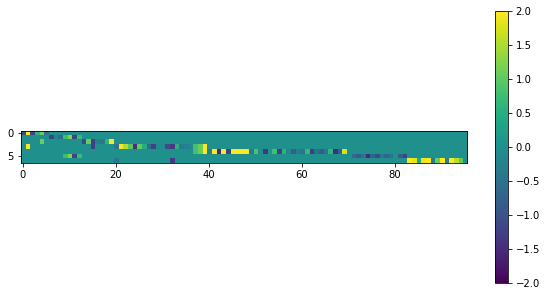

This plot is non-Cancer


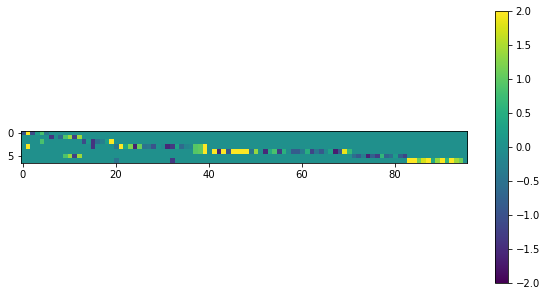

This plot is non-Cancer


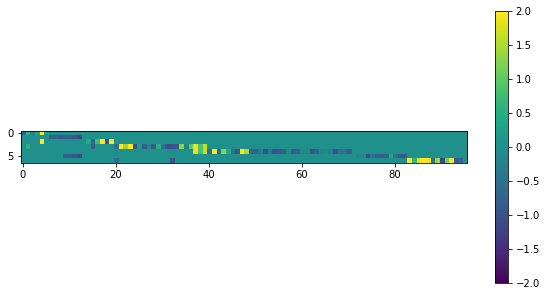

This plot is non-Cancer


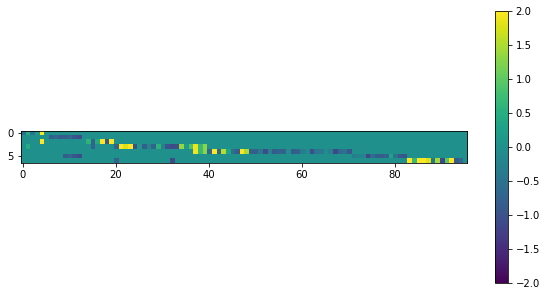

This plot is non-Cancer


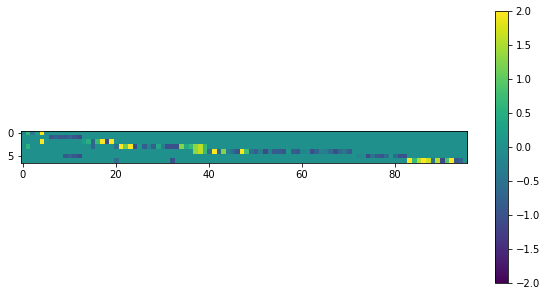

This plot is non-Cancer


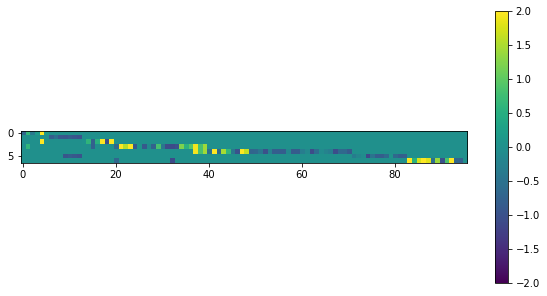

This plot is non-Cancer


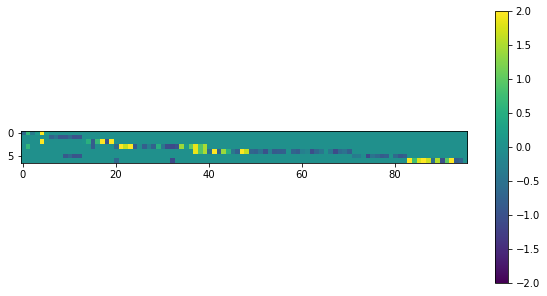

This plot is non-Cancer


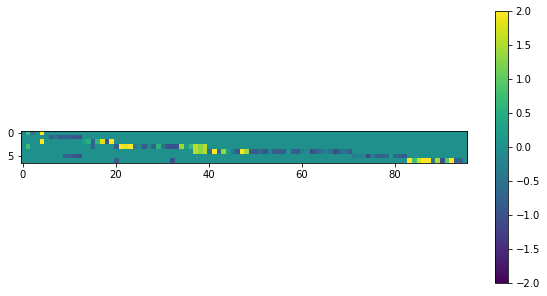

This plot is non-Cancer


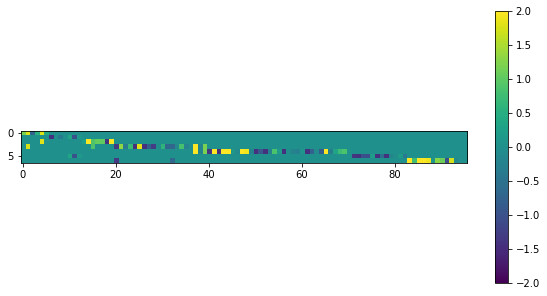

This plot is non-Cancer


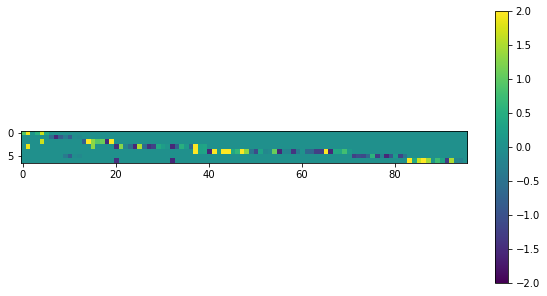

This plot is non-Cancer


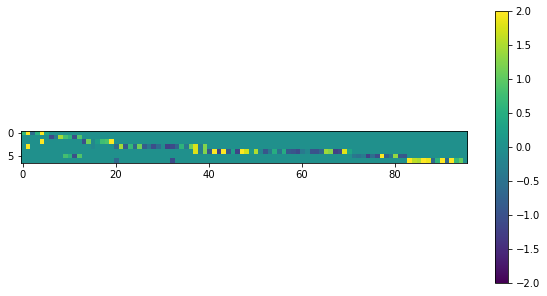

This plot is Cancer


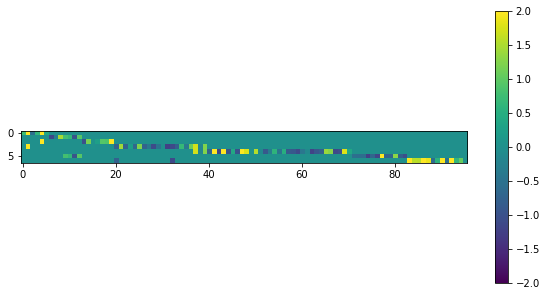

This plot is Cancer


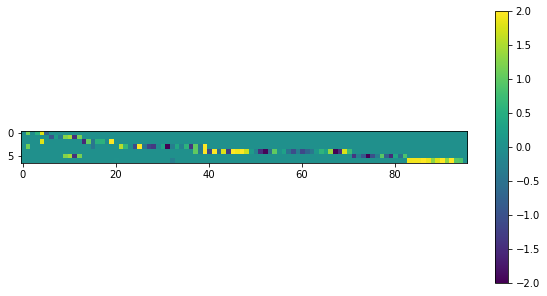

This plot is non-Cancer


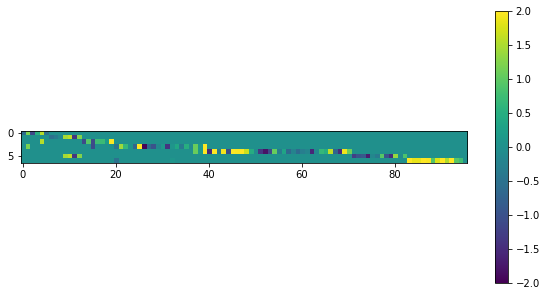

This plot is non-Cancer


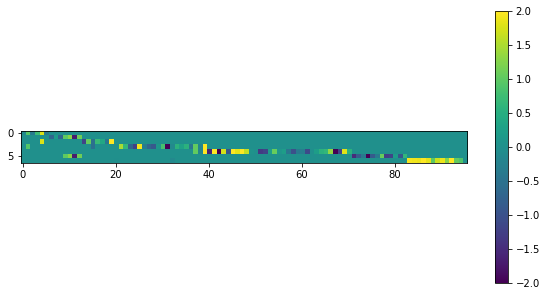

This plot is non-Cancer


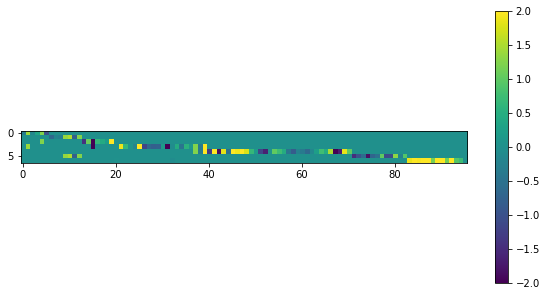

This plot is non-Cancer


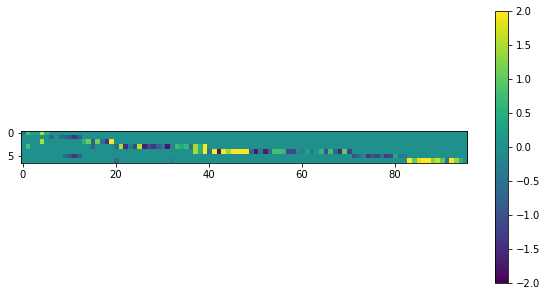

This plot is non-Cancer


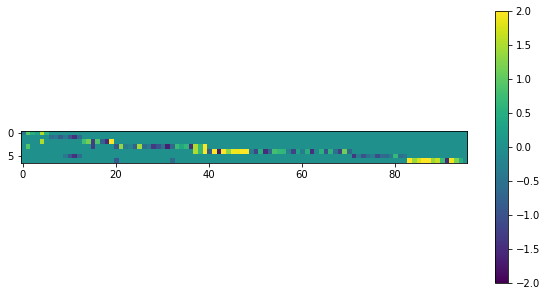

This plot is non-Cancer


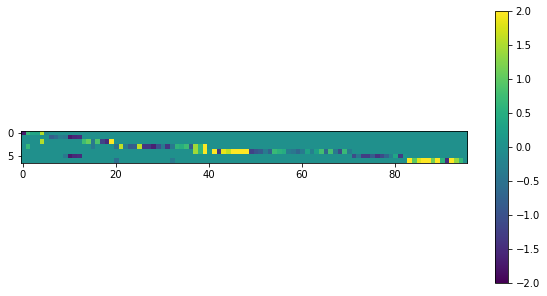

This plot is Cancer


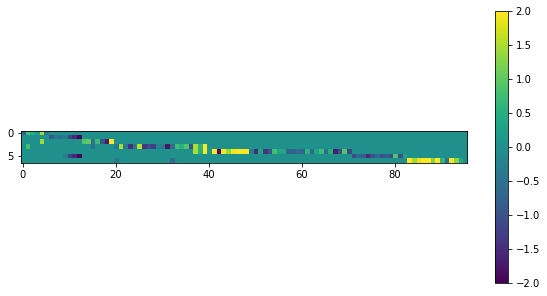

This plot is Cancer


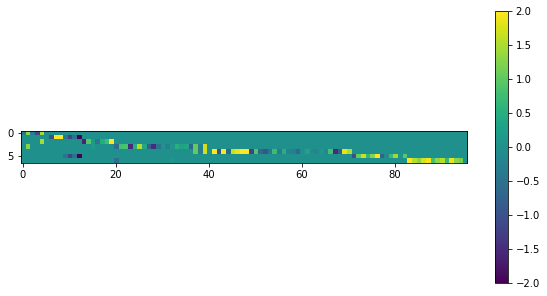

This plot is Cancer


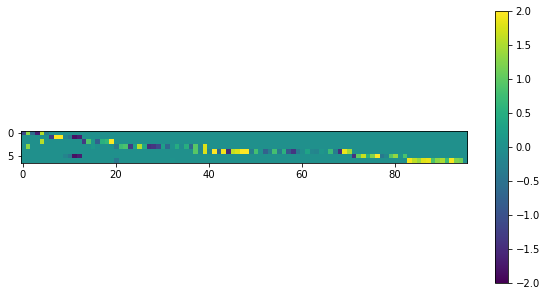

This plot is Cancer


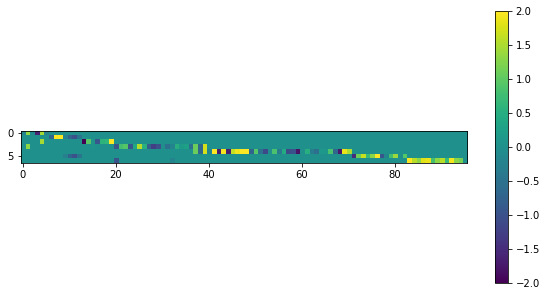

This plot is Cancer


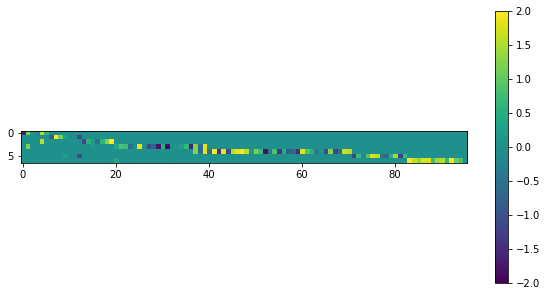

This plot is Cancer


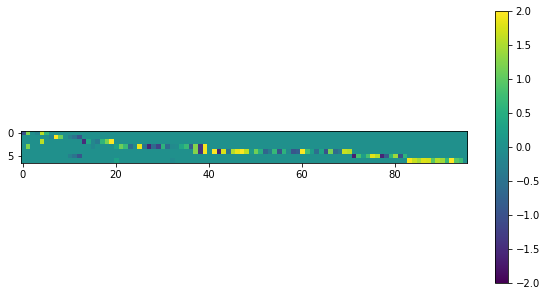

This plot is Cancer


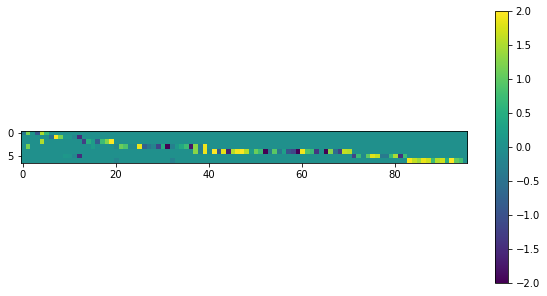

This plot is Cancer


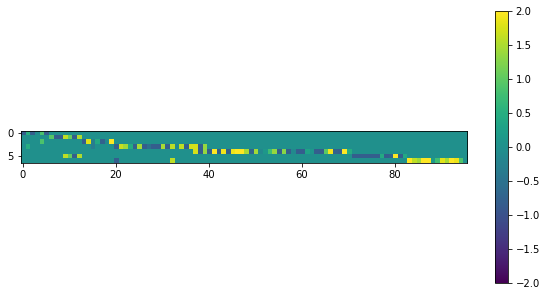

This plot is Cancer


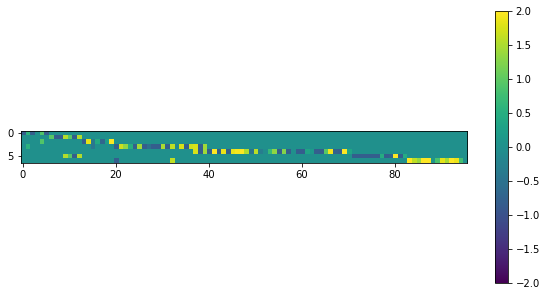

This plot is Cancer


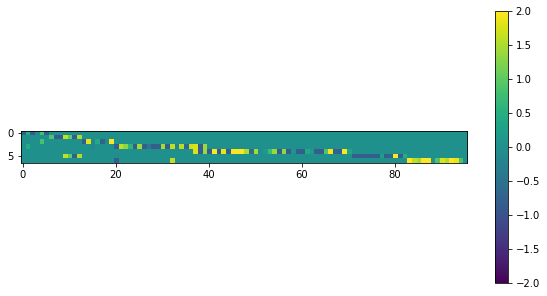

This plot is Cancer


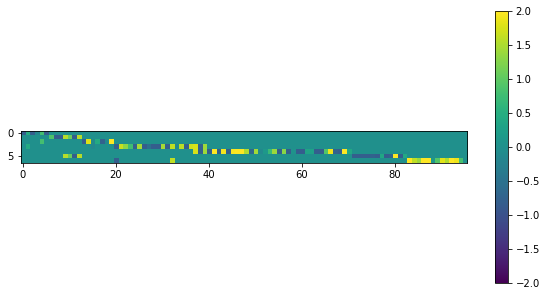

This plot is Cancer


In [66]:
# import matplotlib.pyplot as plt

# for i in range(30):
#     plt.figure(figsize = (10, 5))
#     plt.imshow(dataset_cnn[i], interpolation='nearest', vmin=-2, vmax=2)
#     plt.colorbar()
#     plt.show()
#     if exist_gene_dataset.iloc[i, -1] == 1 :
#         print("This plot is Cancer")
#     else : 
#         print("This plot is non-Cancer")
#     plt.clf()